# Python for Data Science - Final Project - Team 4
## Performance Analysis of Fast Food Companies in the Stock Market

### Getting Started
This notebook is designed to provide a structured approach to exploring and analyzing the datasets of 10 major fast-food companies.
Each dataset contains daily stock market data with information on opening price, closing price, trading volume, and other financial metrics.

### Objective
The primary goal of this notebook is to perform a comprehensive analysis of the stock market performance of these companies over the years. Through this analysis, we aim to:

1. Understand the structure and content of the datasets
2. Explore key metrics such as price trends, trading volumees, and price spreads
3. Visualize and interrupt important patterns and relationships in the data
4. Summarize insights that reveal the financial dynamics of the fast-food industry

### Dataset Overview
The datasets include the following companies:

- BRK-A: Berkshire Hathaway Inc.
- DNUT: Krispy Kreme, Inc.
- DPZ: Domino’s Pizza, Inc.
- LKNCY: Luckin Coffee Inc.
- MCD: McDonald’s Corporation
- PZZA: Papa John’s International, Inc.
- QSR: Restaurant Brands International, Inc.
- SBUX: Starbucks Corporation
- WEN: The Wendy’s Corporation
- YUM: Yum! Brands, Inc.

Each dataset contains the following columns:

- *Date*: Trading date.
- *Open*: Opening price.
- *High*: Highest price during the session.
- *Low*: Lowest price during the session.
- *Close*: Closing price.
- *Adj Close*: Adjusted closing price (accounting for dividends and stock splits).
- *Volume*: Number of shares traded during the session.

---

# Data Preprocessing Summary

## Preprocessing Steps

1. **Missing Volume Handling**:
   - Replaced missing values in the `Volume` column using a 7-day rolling mean.

2. **Missing Values Imputation**:
   - For columns `['Open', 'High', 'Low', 'Close', 'Adj Close']`:
     - Replaced outliers (Z-score > 3 or < -3) with the rolling median (7-day window).
     - Imputed any remaining missing values using the rolling median.

3. **Erroneous Values Correction**:
   - Checked for rows where `Low >= High`:
     - Replaced `Low` values with a 7-day rolling mean.
     - Ensured that `Low` values do not exceed corresponding `High` values by adjusting `Low` to equal `High` where necessary.

4. **Zero Volume Handling**:
   - For rows where `Volume == 0`:
     - If price columns (`['Open', 'High', 'Low', 'Close']`) had different values, replaced them with the mode (most common value).

5. **Uniform Price Handling**:
   - Identified rows where all price columns (`['Open', 'High', 'Low', 'Close']`) were identical:
     - If `Volume` was NaN, replaced it with `0.0`.

6. **Duplicate Dates Check**:
   - Checked for duplicate dates in the `Date` column:
     - Reported the count of duplicates and displayed duplicate rows if found.
     - If no duplicates, confirmed the absence of duplicate dates.

7. **Output**:
   - Saved the cleaned DataFrame for each ticker into a dictionary (`dfs`) for further analysis.

## Key Points
- Used rolling statistics (mean and median) for robust handling of missing values and outliers.
- Ensured consistency in `Low` and `High` values.
- Imputed `Volume` as `0.0` for rows with identical price columns and missing volume.


In [1]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import numpy as np

# Adding the files into a list
files=['Team_4/BRK-A.csv',
       'Team_4/DNUT.csv',
       'Team_4/DPZ.csv',
       'Team_4/LKNCY.csv',
       'Team_4/MCD.csv',
       'Team_4/PZZA.csv',
       'Team_4/QSR.csv',
       'Team_4/SBUX.csv',
       'Team_4/WEN.csv',
       'Team_4/YUM.csv']

i=0

# Step 1: Create a list to store the DataFrames
dfs = {}
tickers = ['BRK-A', 'DNUT', 'DPZ', 'LKNCY', 'MCD', 'PZZA', 'QSR', 'SBUX', 'WEN', 'YUM']

for ticker, file in zip(tickers, files):

    # Step 1: Load the dataset
    df = pd.read_csv(file, index_col=False)

    print(df.isnull().sum())

    print('initialdataset',df.head(16))

    # Handling Missing Volume
    df['Volume'] =df['Volume'].fillna(df['Volume'].rolling(window=7, min_periods=1).mean())

    
    # Impute missing values for each column using rolling mean
    columns_to_impute = ['Open', 'High', 'Low', 'Close', 'Adj Close']
    # Handling Outliers
    for column in columns_to_impute:
        # Calculate mean and standard deviation
        mean = df[column].mean()
        std_dev = df[column].std()

        # Calculate Z-scores
        z_scores = (df[column] - mean) / std_dev

        # Identify outlier indices (Z-score > 3 or < -3)
        outlier_indices = df[np.abs(z_scores) > 3].index

        # Replace outliers with the rolling median
        for idx in outlier_indices:
            df.at[idx, column] = df[column].rolling(window=7, min_periods=1).median().iloc[idx]

        # Fill any remaining missing values with rolling median
        df[column] = df[column].fillna(df[column].rolling(window=7, min_periods=1).median())

   


    # Step 1: Identify rows where Volume == 0
    volume_zero_rows = df['Volume'] == 0

    # Step 2: Apply the logic to each row where Volume is 0
    for index, row in df[volume_zero_rows].iterrows():
        # Step 3: Check if any of Open, High, Low, or Close are different
        values = ['Open', 'High', 'Low', 'Close']
        values_dict = row[values]

        # If any value is different, replace it with the common value
        unique_values = values_dict.unique()
        if len(unique_values) > 1:  # More than one unique value means there is a difference
            common_value = values_dict.mode()[0]  # Find the most common value
            for col in values:
                if row[col] != common_value:
                    df.at[index, col] = common_value  # Replace with the common value


    # Step 1: Identify rows where all price columns are the same
    price_columns = ['Open', 'High', 'Low', 'Close']
    price_same_rows = (df[price_columns].nunique(axis=1) == 1)  # Check if all values are the same across price columns

    # Step 2: Check if Volume is NaN for those rows
    volume_empty_rows = price_same_rows & df['Volume'].isna()

    # Step 3: Replace NaN Volume with 0.0 (in float) for those rows
    df.loc[volume_empty_rows, 'Volume'] = 0.0
  

    print('Finaldataset',df.head(16))

    # Check for duplicate dates
    if 'Date' in df.columns:
        duplicate_dates = df['Date'].duplicated().sum()
        if duplicate_dates > 0:
            print(f"There are {duplicate_dates} duplicate date(s).")
            print("Duplicate rows:")
            print(df[df['Date'].duplicated(keep=False)])
        else:
            print("No duplicate dates found.")
    else:
        print("The column 'Date' does not exist in the DataFrame.")
    
    # Drop duplicate rows and count them
    initial_row_count = len(df)
    df = df.drop_duplicates()
    duplicates_dropped = initial_row_count - len(df)

    print(f"{duplicates_dropped} duplicate row(s) were dropped.")

    # Drop duplicates based on 'Date' column (if applicable)
    if 'Date' in df.columns:
        initial_row_count = len(df)
        df = df.drop_duplicates(subset='Date', keep='first')
        duplicates_dropped = initial_row_count - len(df)

        print(f"{duplicates_dropped} duplicate date(s) were dropped.")

    # Step 1: Check for rows where Low >= High
    erroneous_rows = df['Low'] >= df['High']

    # Step 2: Replace erroneous Low values with the column's rolling average
    low_avg = df['Low'].rolling(window=7, min_periods=1).mean()

    # Replace Low values where Low >= High
    df.loc[erroneous_rows, 'Low'] = low_avg[erroneous_rows]

    # Step 3: Ensure Low does not exceed High after correction
    df.loc[df['Low'] >= df['High'], 'Low'] = df['High']


    dfs[ticker]=df
 
 

Date           0
Open         548
High         550
Low          550
Close        550
Adj Close    544
Volume       561
dtype: int64
initialdataset           Date   Open          High           Low  Close     Adj Close  \
0   1980-03-17  290.0  3.100000e+02  2.900000e+02  290.0  2.900000e+02   
1   1980-03-18  290.0  2.900000e+02  2.900000e+02  290.0  2.900000e+02   
2   1980-03-19  290.0  3.100000e+02  2.900000e+02  290.0  2.900000e+02   
3   1980-03-20  290.0  2.900000e+02  2.900000e+02  290.0  2.900000e+02   
4   1980-03-21  290.0  2.900000e+02  2.900000e+02  290.0  2.900000e+02   
5   1980-03-24  290.0  2.900000e+02  2.700000e+02  270.0           NaN   
6   1980-03-25  270.0  2.700000e+02  2.700000e+02  270.0  2.700000e+02   
7   1980-03-26  270.0  2.700000e+02  2.700000e+02  270.0  2.700000e+02   
8   1980-03-27  270.0  2.700000e+02  2.700000e+02  270.0  2.700000e+02   
9   1980-03-28  270.0  2.700000e+02  2.700000e+02  270.0  2.700000e+02   
10  1980-03-31  270.0  2.800000e+02  2.

# **EXERCISE 1**  
---
**For Each Dataset**  
- **Print the number of rows and columns**  
- **Display the column names and their data types**  
🎉


In [2]:
import pandas as pd

summary = []

for ticker, df in dfs.items():
    print(f"--- Processing Dataset for {ticker} ---")
    
    num_rows, num_cols = df.shape
    
    print(f"Number of rows: {num_rows}")
    print(f"Number of columns: {num_cols}\n")
    
    print("Column Names and Data Types:")
    for col, dtype in df.dtypes.items():
        print(f"{col}: {dtype}")
    
    print("\n") 
    
    summary.append({
        'Ticker': ticker,
        'Rows': num_rows,
        'Columns': num_cols,
        'Column Info': df.dtypes.to_dict()
    })

summary_df = pd.DataFrame(summary)

print("Summary of all datasets:")
print(summary_df)


--- Processing Dataset for BRK-A ---
Number of rows: 11222
Number of columns: 7

Column Names and Data Types:
Date: object
Open: float64
High: float64
Low: float64
Close: float64
Adj Close: float64
Volume: float64


--- Processing Dataset for DNUT ---
Number of rows: 810
Number of columns: 7

Column Names and Data Types:
Date: object
Open: float64
High: float64
Low: float64
Close: float64
Adj Close: float64
Volume: float64


--- Processing Dataset for DPZ ---
Number of rows: 5083
Number of columns: 7

Column Names and Data Types:
Date: object
Open: float64
High: float64
Low: float64
Close: float64
Adj Close: float64
Volume: float64


--- Processing Dataset for LKNCY ---
Number of rows: 1345
Number of columns: 7

Column Names and Data Types:
Date: object
Open: float64
High: float64
Low: float64
Close: float64
Adj Close: float64
Volume: float64


--- Processing Dataset for MCD ---
Number of rows: 14652
Number of columns: 7

Column Names and Data Types:
Date: object
Open: float64
High: fl

# **EXERCISE 2**  
---

### Extract Rows for 2023
- **Filter all rows where the date is in the year 2023**  
- **Print the number of rows**  
- **Visualize the Close price trend for this period**  
🎉


--- Processing Dataset for BRK-A ---
Number of rows for 2023: 250


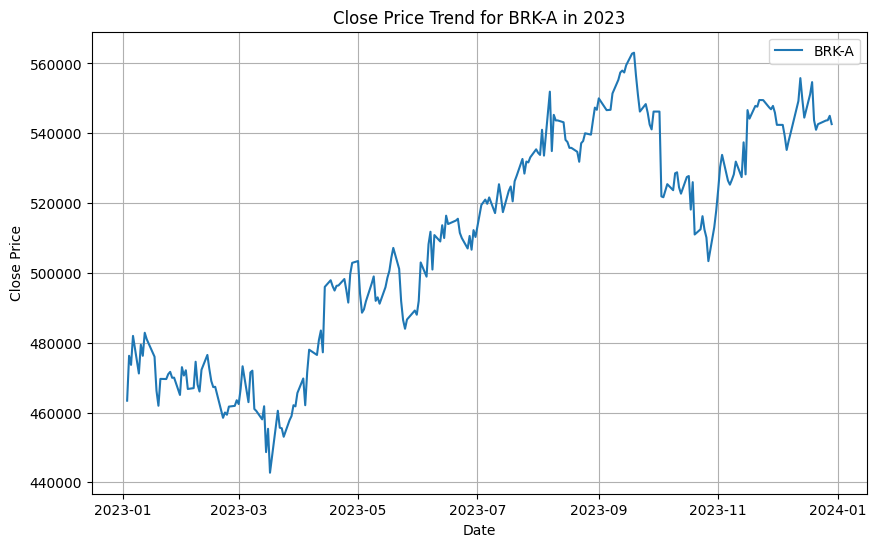



--- Processing Dataset for DNUT ---
Number of rows for 2023: 250


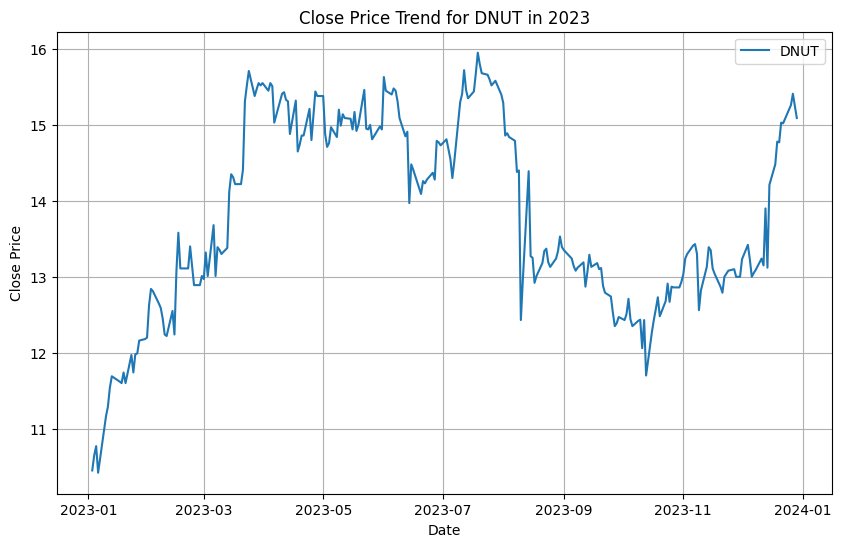



--- Processing Dataset for DPZ ---
Number of rows for 2023: 250


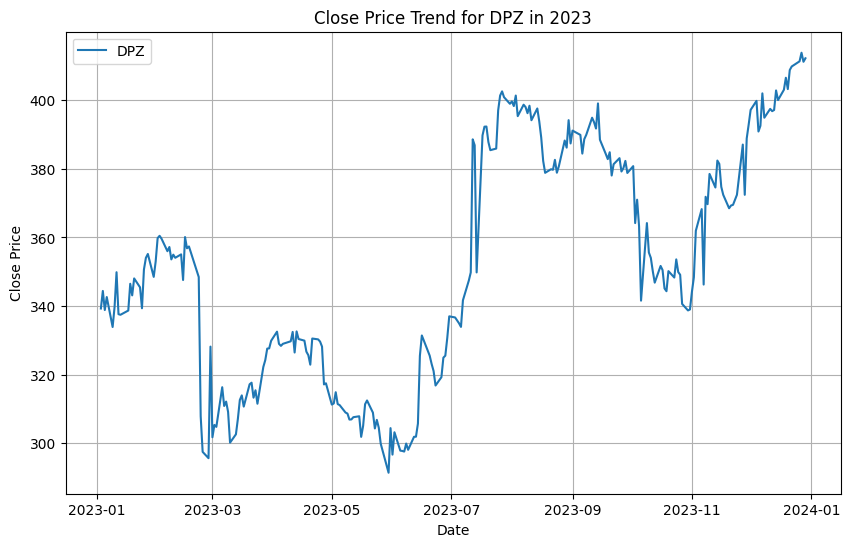



--- Processing Dataset for LKNCY ---
Number of rows for 2023: 250


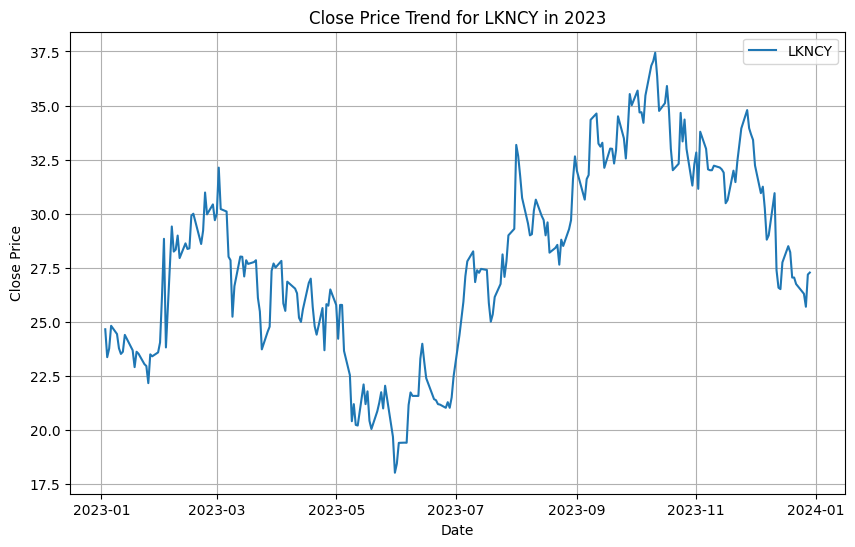



--- Processing Dataset for MCD ---
Number of rows for 2023: 250


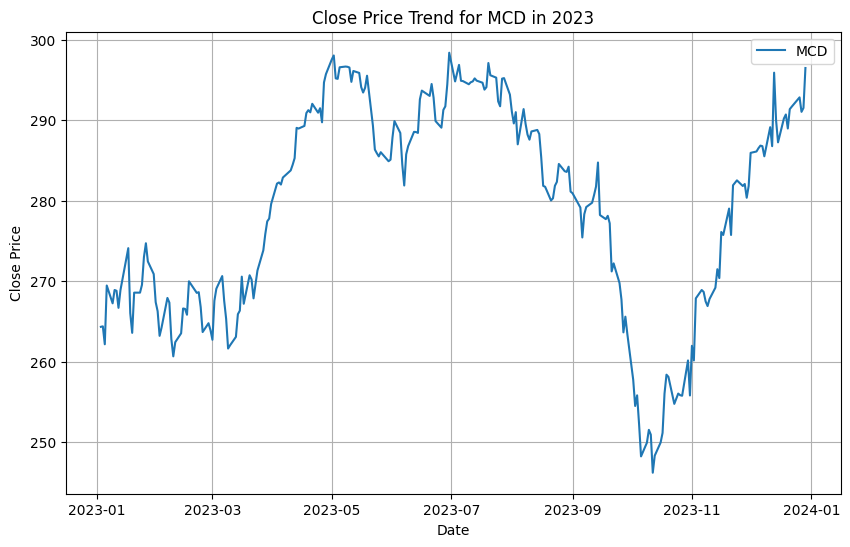



--- Processing Dataset for PZZA ---
Number of rows for 2023: 250


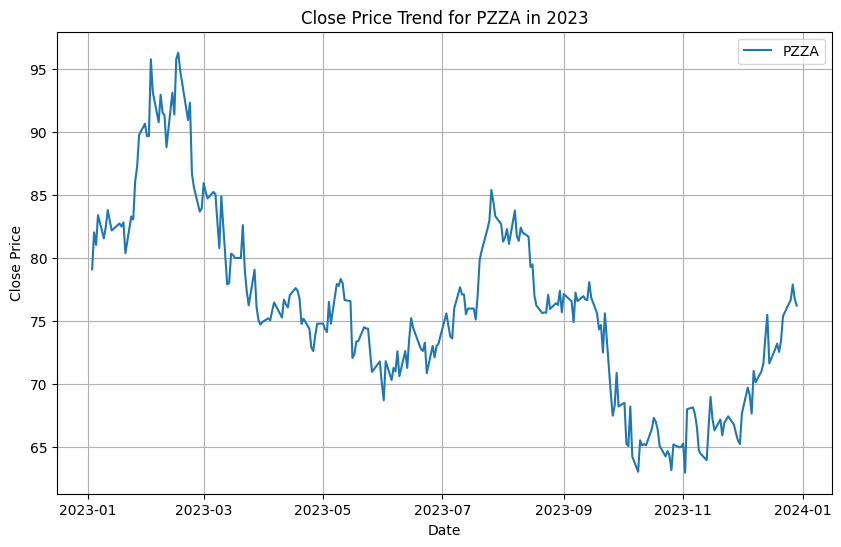



--- Processing Dataset for QSR ---
Number of rows for 2023: 250


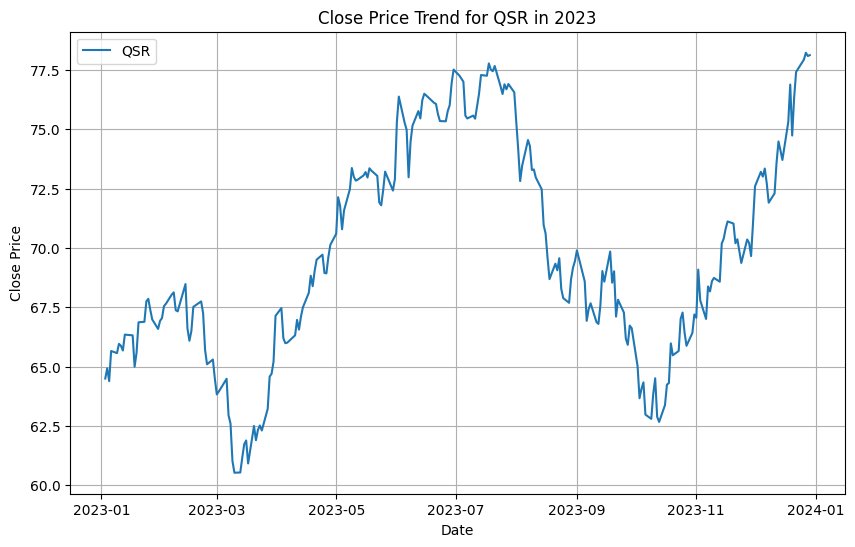



--- Processing Dataset for SBUX ---
Number of rows for 2023: 250


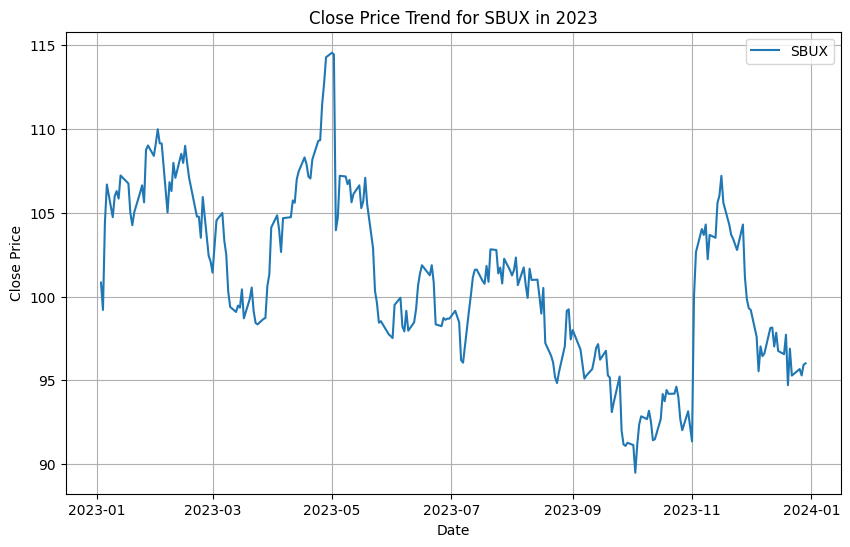



--- Processing Dataset for WEN ---
Number of rows for 2023: 250


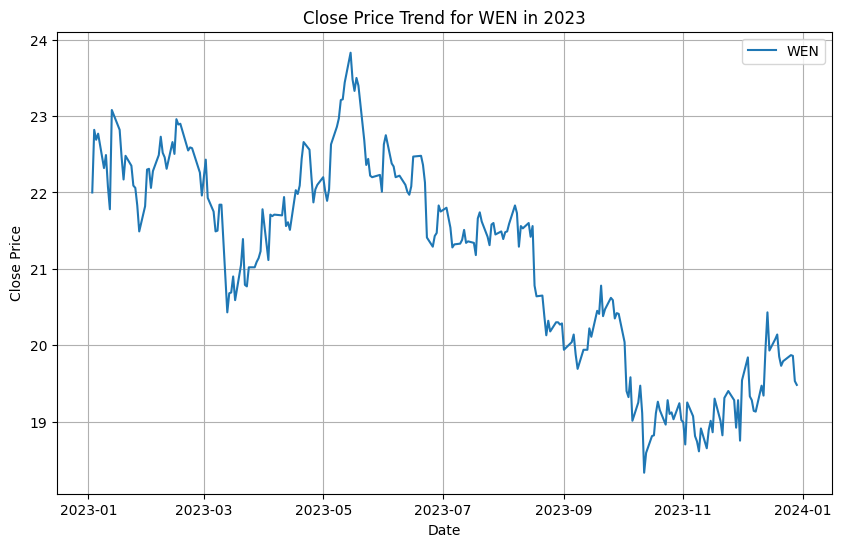



--- Processing Dataset for YUM ---
Number of rows for 2023: 250


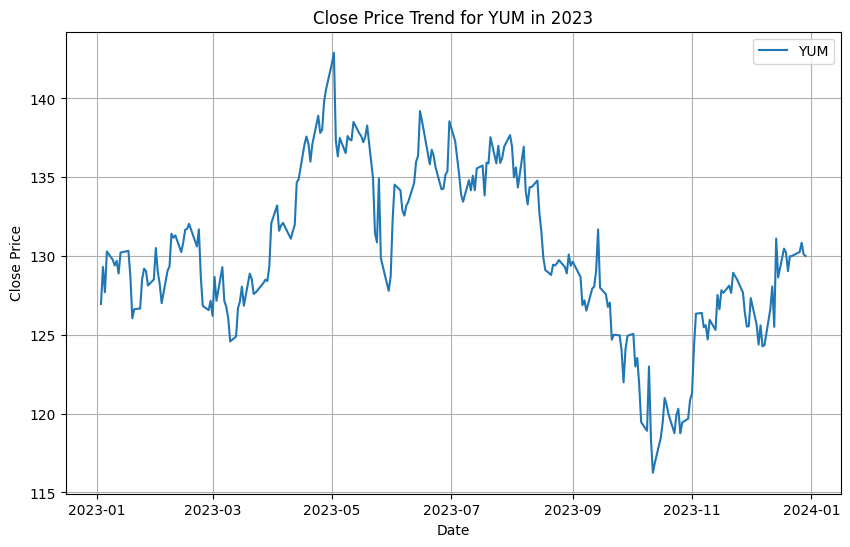

In [3]:
import matplotlib.pyplot as plt

for ticker, df in dfs.items():
    print(f"--- Processing Dataset for {ticker} ---")
    
    if 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'])
    else:
        print(f"'Date' column not found in {ticker}. Skipping...")
        continue
    
    df_2023 = df[df['Date'].dt.year == 2023]
    
    num_rows_2023 = len(df_2023)
    print(f"Number of rows for 2023: {num_rows_2023}")
    
    if num_rows_2023 == 0:
        print(f"No data for 2023 in {ticker}. no visualization...")
        continue
    
    # Visualize the Close price trend for 2023
    if 'Close' in df_2023.columns:
        plt.figure(figsize=(10, 6))
        plt.plot(df_2023['Date'], df_2023['Close'], label=ticker)
        plt.title(f"Close Price Trend for {ticker} in 2023")
        plt.xlabel("Date")
        plt.ylabel("Close Price")
        plt.grid(True)
        plt.legend()
        plt.show()
    else:
        print(f"'Close' column not found in {ticker}. no visualization...")
    
    print("\n")


We choose the **line chart** to have a clear and concise way to observe fluctuations, growth, or declines in stock prices over time in 2023. The y-axis which represents the close price is customized for each dataset because the price ranges vary significantly across the different stocks.

# **EXERCISE 3**  
---

**Find the Day with Highest Close Price**  
- **For each company, identify the day with the highest Close price**  
- **Display the date and the corresponding Close price**  
🎉


In [4]:
for ticker, df in dfs.items():
    print(f"--- Processing Dataset for {ticker} ---")
    
    if 'Date' in df.columns and 'Close' in df.columns:
        max_close_row = df.loc[df['Close'].idxmax()]
        
        highest_close_date = max_close_row['Date']
        highest_close_price = max_close_row['Close']
        
        display(f"Highest Close Price for {ticker}:")
        display(f"Date: {highest_close_date}, Close Price: {highest_close_price}")
    else:
        display(f"Required columns ('Date' and/or 'Close') not found in {ticker}. ")


--- Processing Dataset for BRK-A ---


'Highest Close Price for BRK-A:'

'Date: 2024-09-03 00:00:00, Close Price: 715910.0'

--- Processing Dataset for DNUT ---


'Highest Close Price for DNUT:'

'Date: 2021-07-01 00:00:00, Close Price: 21.0'

--- Processing Dataset for DPZ ---


'Highest Close Price for DPZ:'

'Date: 2021-12-31 00:00:00, Close Price: 564.3300170898438'

--- Processing Dataset for LKNCY ---


'Highest Close Price for LKNCY:'

'Date: 2020-01-16 00:00:00, Close Price: 48.52999877929688'

--- Processing Dataset for MCD ---


'Highest Close Price for MCD:'

'Date: 2024-01-19 00:00:00, Close Price: 300.5299987792969'

--- Processing Dataset for PZZA ---


'Highest Close Price for PZZA:'

'Date: 2021-11-04 00:00:00, Close Price: 140.00999450683594'

--- Processing Dataset for QSR ---


'Highest Close Price for QSR:'

'Date: 2024-03-13 00:00:00, Close Price: 82.75'

--- Processing Dataset for SBUX ---


'Highest Close Price for SBUX:'

'Date: 2021-07-26 00:00:00, Close Price: 126.05999755859376'

--- Processing Dataset for WEN ---


'Highest Close Price for WEN:'

'Date: 1980-05-07 00:00:00, Close Price: 63.3963421596517'

--- Processing Dataset for YUM ---


'Highest Close Price for YUM:'

'Date: 2023-05-02 00:00:00, Close Price: 142.89999389648438'

# **EXERCISE 4**  
---

### **Monthly Average Close Price Analysis**  
- **Group the data by month and calculate the average Close price for each company**  
- **Plot these monthly averages for 3 companies and compare them**  
- **Justify the chart selection**  
🎉


{'BRK-A': YearMonth
1980-03       278.181818
1980-04       262.857143
1980-05       301.190476
1980-06       312.857143
1980-07       324.318182
               ...      
2024-05    617918.227273
2024-06    617500.578947
2024-07    641800.590909
2024-08    665209.477273
2024-09    690682.384615
Freq: M, Name: Close, Length: 535, dtype: float64, 'DNUT': YearMonth
2021-07    17.358095
2021-08    15.613636
2021-09    15.188572
2021-10    13.680000
2021-11    14.150714
2021-12    16.160454
2022-01    16.232250
2022-02    14.486316
2022-03    14.438043
2022-04    13.919750
2022-05    13.824286
2022-06    13.701429
2022-07    14.181500
2022-08    13.416522
2022-09    11.962143
2022-10    13.219048
2022-11    14.819524
2022-12    13.186190
2023-01    11.486000
2023-02    12.811053
2023-03    14.306739
2023-04    15.172632
2023-05    15.006818
2023-06    14.772857
2023-07    15.364000
2023-08    13.712174
2023-09    12.950750
2023-10    12.535227
2023-11    13.092857
2023-12    14.086500
2024-0

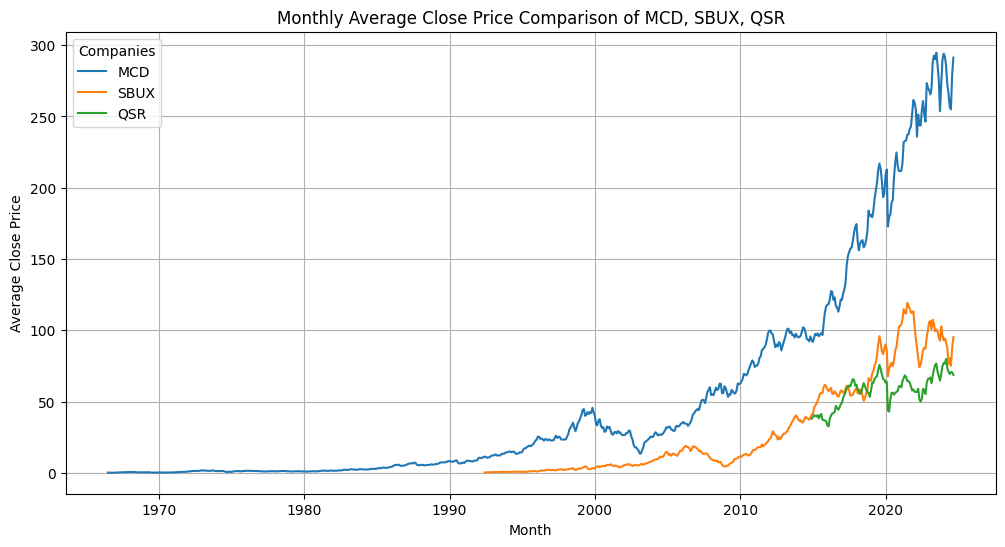

In [5]:
monthly_averages = {}

for ticker, df in dfs.items():    
    if 'Date' in df.columns and 'Close' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'])
        df['YearMonth'] = df['Date'].dt.to_period('M')
        monthly_avg = df.groupby('YearMonth')['Close'].mean()
        monthly_averages[ticker] = monthly_avg
    else:
        print(f"Required columns ('Date' and/or 'Close') not found in {ticker}. Skipping...\n")

print(monthly_averages)

# Plot monthly average Close prices for 3 companies
selected_tickers = ['MCD', 'SBUX', 'QSR']

plt.figure(figsize=(12, 6))

for ticker in selected_tickers:
    if ticker in monthly_averages:
        plt.plot(monthly_averages[ticker].index.to_timestamp(), monthly_averages[ticker], label=ticker)

plt.title("Monthly Average Close Price Comparison of MCD, SBUX, QSR")
plt.xlabel("Month")
plt.ylabel("Average Close Price")
plt.legend(title="Companies")
plt.grid(True)
plt.show()

### Why we slected the line chart:

Becaue the line chart effectively shows trends over time. It helps us clearly see how the monthly average Close prices change over time for the three companies. By connecting the data points, it shows trends and patterns, like steady growth, sudden spikes, or seasonal dips, making it easier to interpret the performance.

Since we’re comparing three companies MCD, SBUX and QSR, the line chart works well because it can display multiple datasets on the same plot without looking cluttered. Each company has its own line, so we can easily spot differences, similarities, and how they behave over time. A bar chart or scatter plot wouldn’t work as effectively here. The line chart emphasizes the flow of time and lets us quickly understand how prices progress from month to month. So, according to the line chart, we learned that MCD has experienced the most significant growth over time, particularly after 2000, while SBUX and QSR showed moderate growth, with SUX emerging more prominently after its IPO in the 1990s.

# **EXERCISE 5**  
---

## 📝 **Description**  

### **5: Yearly Average Close Price Comparison**  
- **For each company:**  
  - **Compute the yearly average of the Close price**  
  - **Plot a comparison of yearly averages for all companies on a chart**  
- **Justify your chart selection**  
🎉

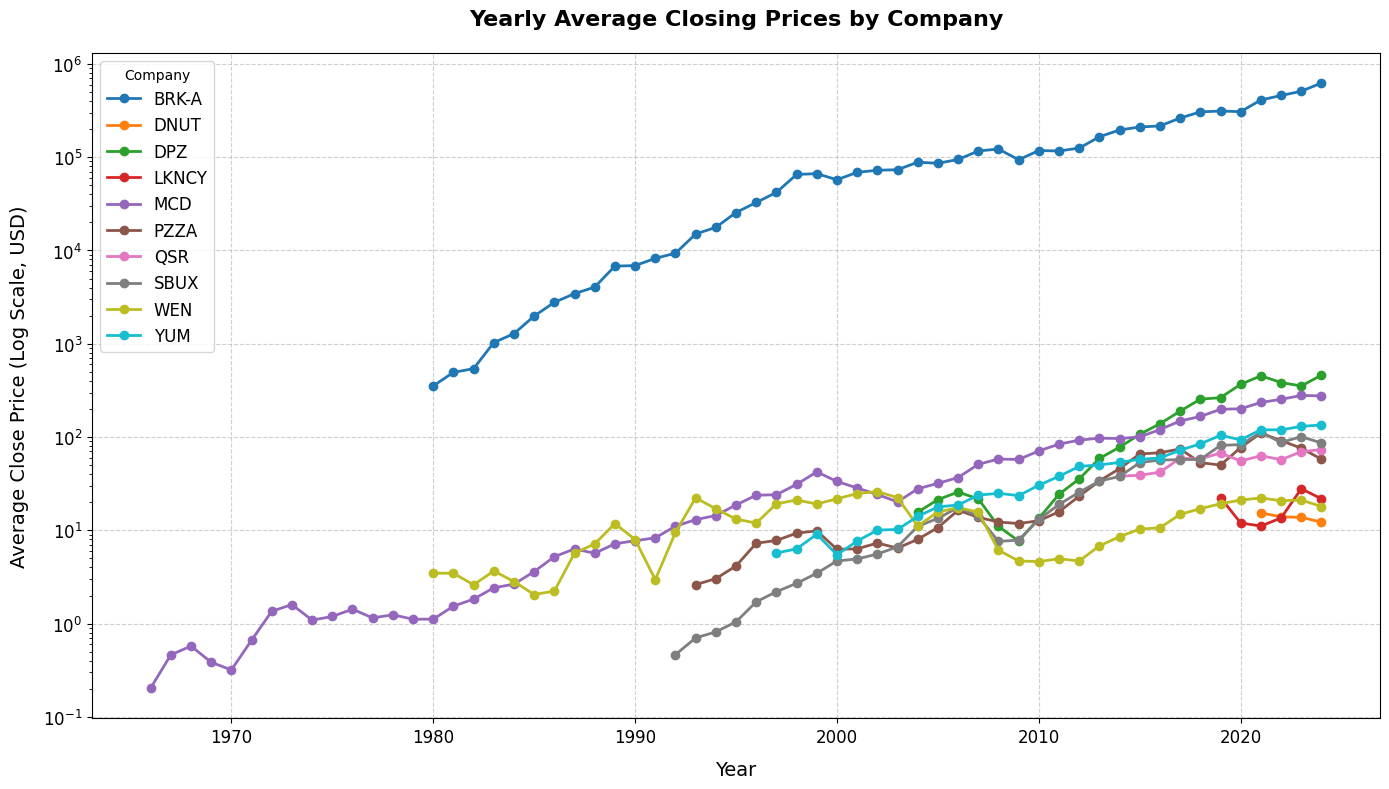

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

# Initialize a dictionary to store yearly average closing prices for each company
company_yearly_averages = {}

# Process each preprocessed DataFrame in the dfs dictionary
for company_name, df in dfs.items():
        # Ensure the Date column is in datetime format
        df['Date'] = pd.to_datetime(df['Date'])
        
        # Extract the year from the Date column
        df['Year'] = df['Date'].dt.year
        
        # Calculate the yearly average of the 'Close' prices
        yearly_average = df.groupby('Year')['Close'].mean()
        
        # Store the results in the dictionary
        company_yearly_averages[company_name] = yearly_average

# Combine all company data into a single DataFrame for visualization
yearly_average_df = pd.DataFrame(company_yearly_averages)

# Plot the data: Yearly Average Close Prices
plt.figure(figsize=(14, 8))  # Set figure size
plt.title("Yearly Average Closing Prices by Company", fontsize=16, fontweight='bold', pad=20)

# Plot each company's yearly average closing prices
for company in yearly_average_df.columns:
    plt.plot(yearly_average_df.index, yearly_average_df[company], marker='o', linewidth=2, label=company)

# Use a logarithmic scale for the y-axis to address large differences in values
plt.yscale('log')

# Customize the x-axis and y-axis
plt.xlabel("Year", fontsize=14, labelpad=10)
plt.ylabel("Average Close Price (Log Scale, USD)", fontsize=14, labelpad=10)

# Add gridlines
plt.grid(visible=True, linestyle='--', alpha=0.6)

# Add a legend for company names
plt.legend(title="Company", loc="upper left", fontsize=12)

# Enhance x-axis and y-axis ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Display the plot
plt.tight_layout()
plt.show()

## Line Chart Suitability:

Line charts are perfect for displaying trends over time, which aligns with the objective of comparing yearly average close prices for multiple companies.
The use of lines connecting data points emphasizes the continuity and progression of average prices year over year.
Logarithmic Scale Justification:

A logarithmic scale on the y-axis is ideal when there are large differences in the values of the companies' closing prices. It ensures that smaller values are still visible and comparable alongside larger values, avoiding distortion in the visualization.
This choice prevents dominant values from overshadowing smaller trends, allowing for a fair comparison across all companies.
Comparison Across Companies:

The individual lines for each company with distinct markers make it easy to compare their yearly trends while maintaining clarity and avoiding clutter.
Visualization Enhancements:

The addition of a grid, distinct markers, and a legend aids in readability and clarity, allowing the audience to distinguish between the companies easily.
Titles, axis labels, and formatted ticks ensure the plot is professional and understandable for non-expert viewers.
Alternative Chart Consideration:

While a grouped bar chart could also be used, it would not effectively convey the trend over time. The line chart, on the other hand, captures the temporal changes more dynamically.

# **EXERCISE 6**  
---

### **Monthly Price Range Visualization**  
- **For each company, create a plot showing the range of prices for each month**  
- **Justify the chart selection**  
🎉


## Why Use a Heatmap for Stock Market Price Ranges?

The heatmap is ideal for analyzing stock market price ranges as it visually highlights patterns and trends across years (rows) and months (columns). Its key advantages include:

1. **Time-Based Comparison**  
   - You can cleary see the differences for each month and year, even though there are multiple years. It provides a simple format to read and understand even though there is a high magnitude of data.

2. **Color Gradients**  
   - Makes the copmplex data more intuitive by asssinging colors.

3. **Outlier Detection**  
   - You can easily identify unusual events like crashes or rallies and allows you to analyze potential causes such as earnings reports, economic announcements, or geopolitical events that match this unusual number on your heatmap.


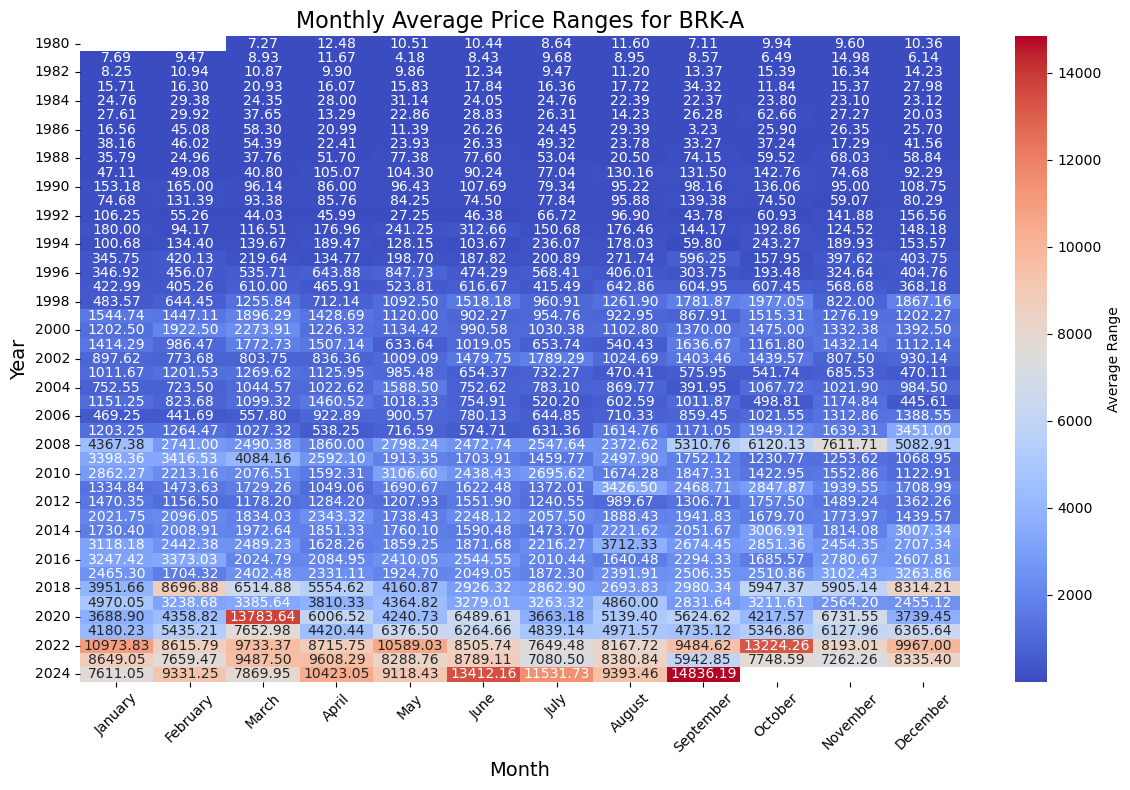

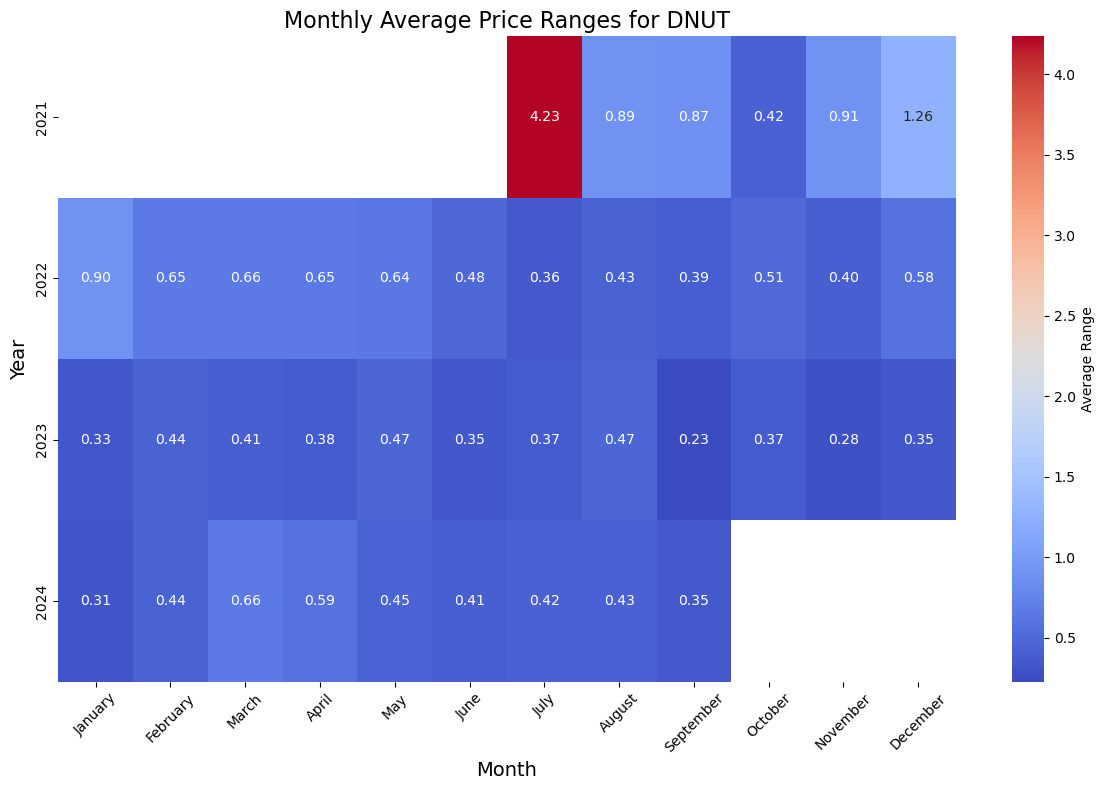

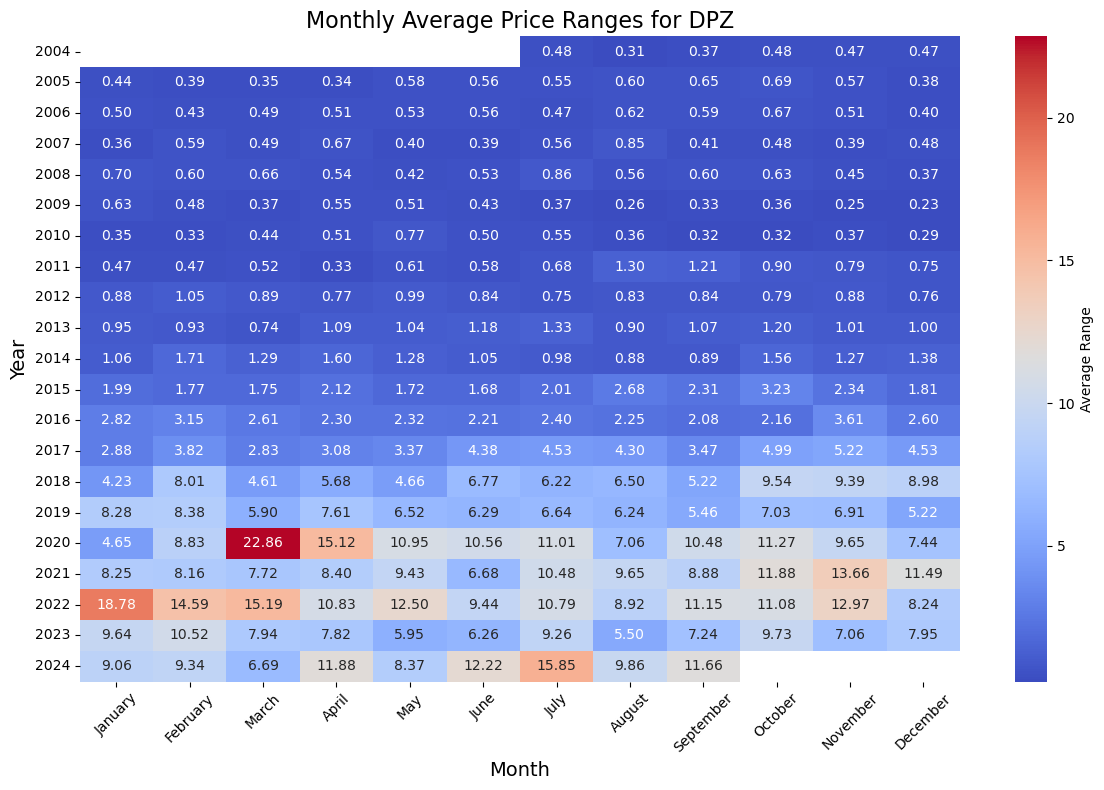

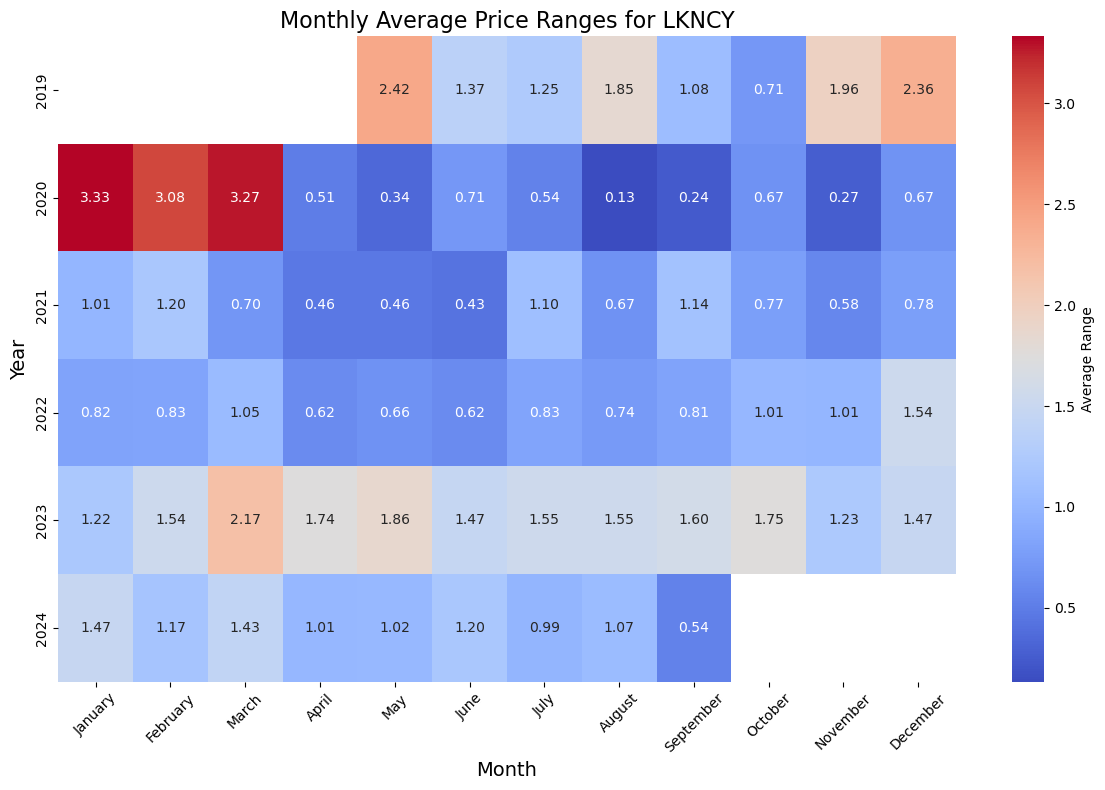

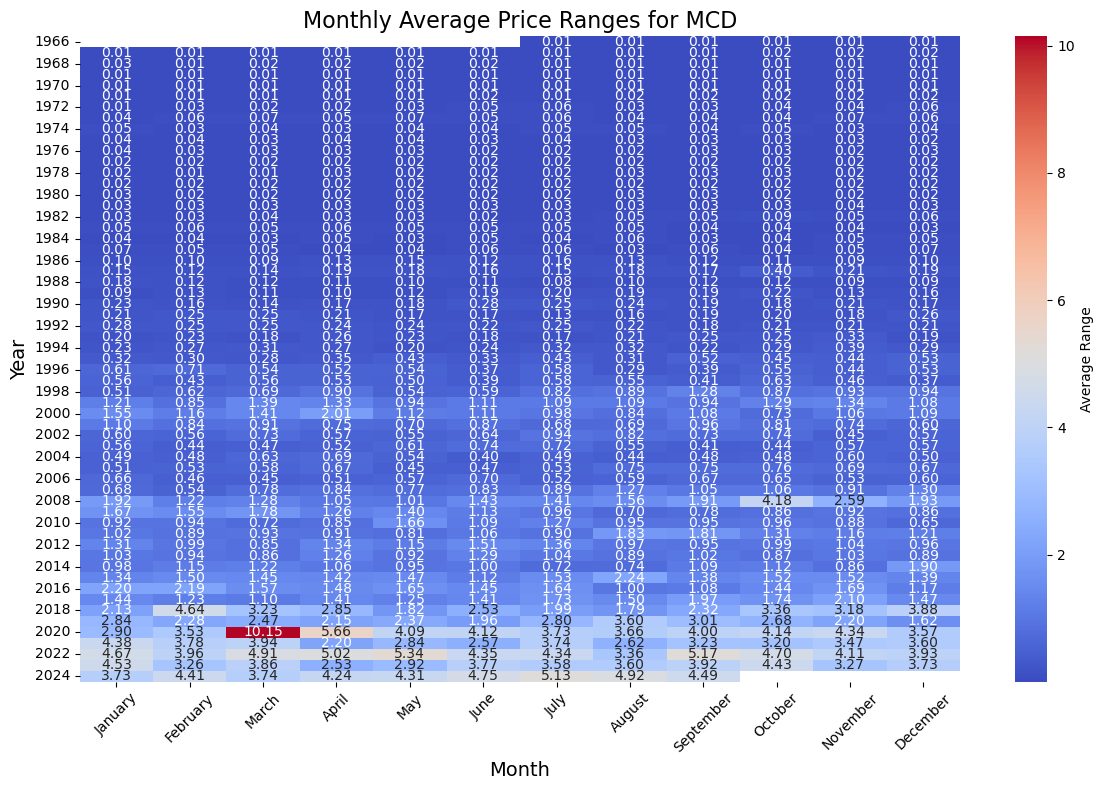

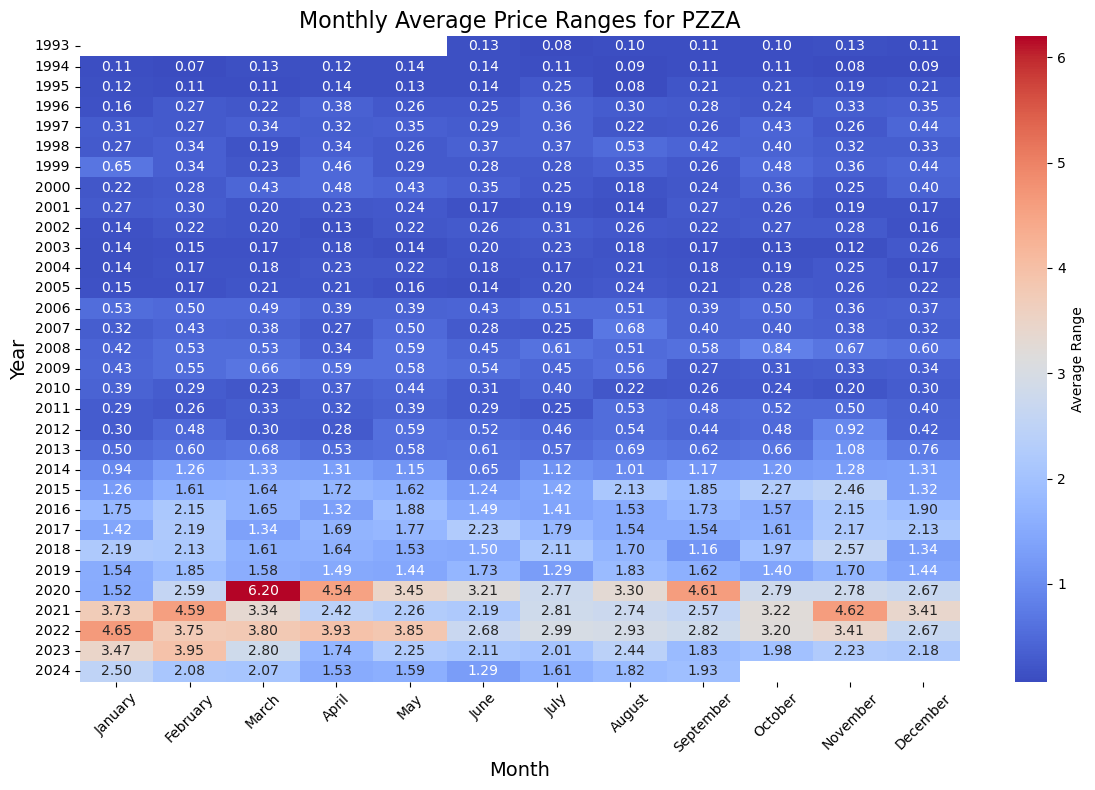

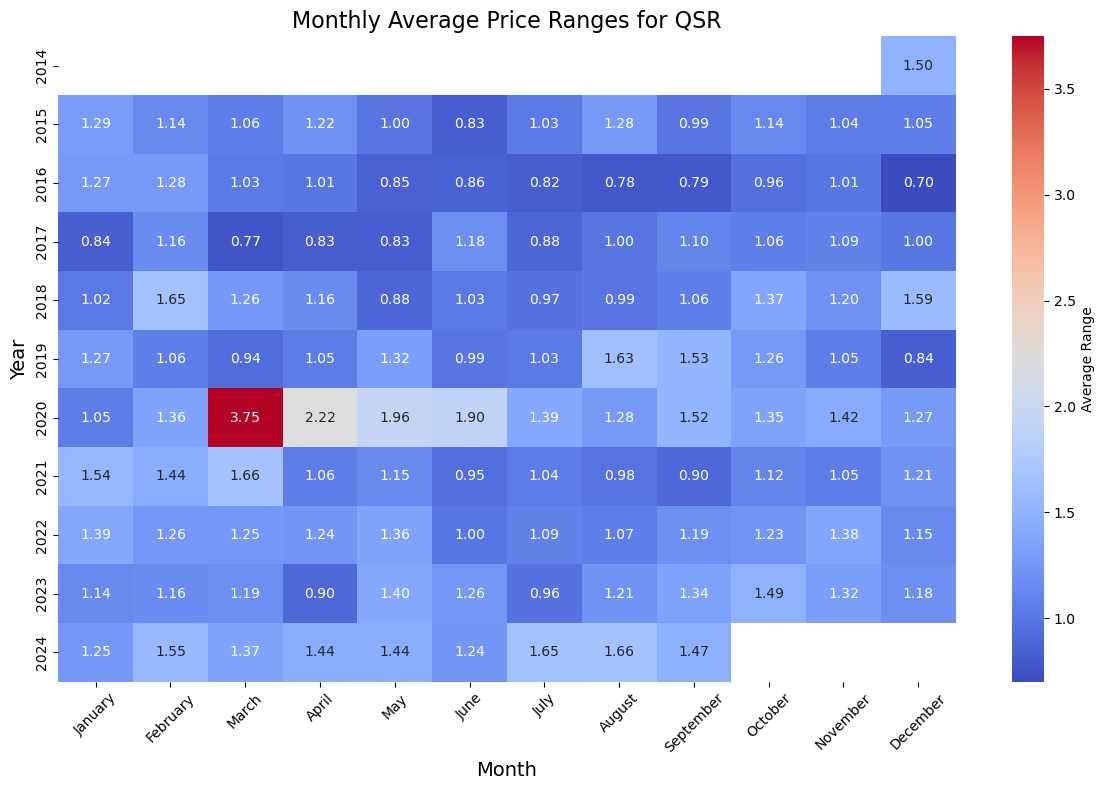

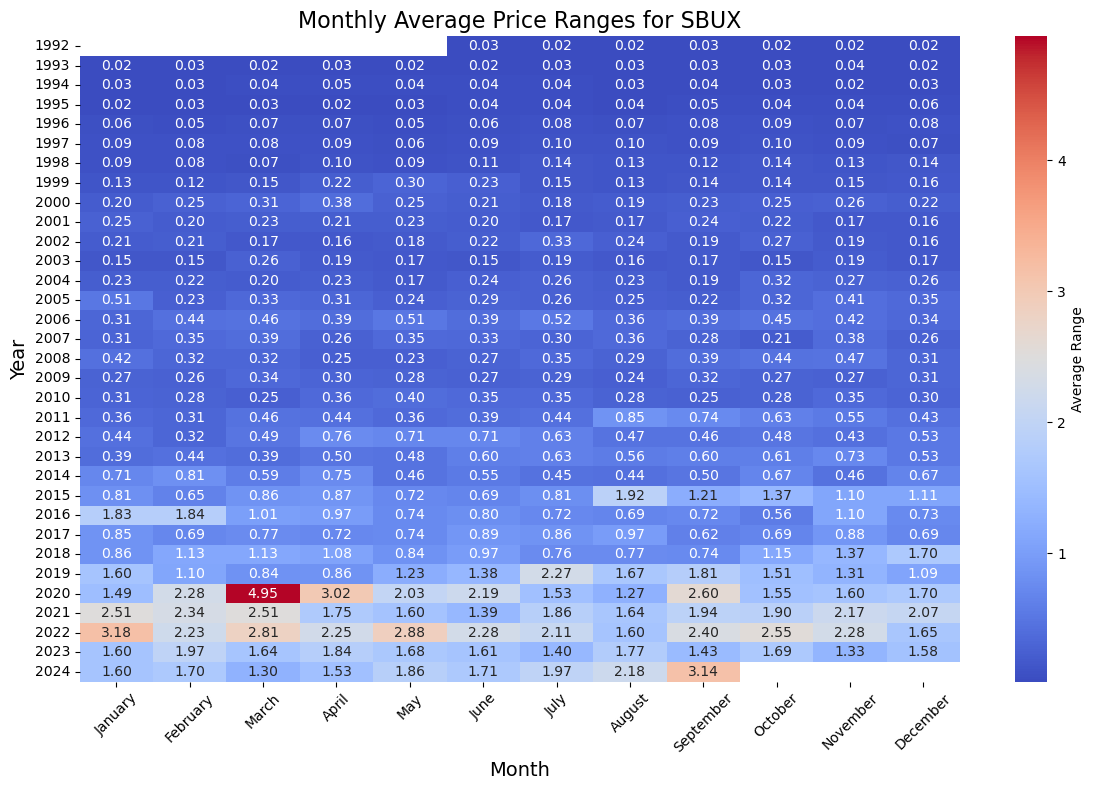

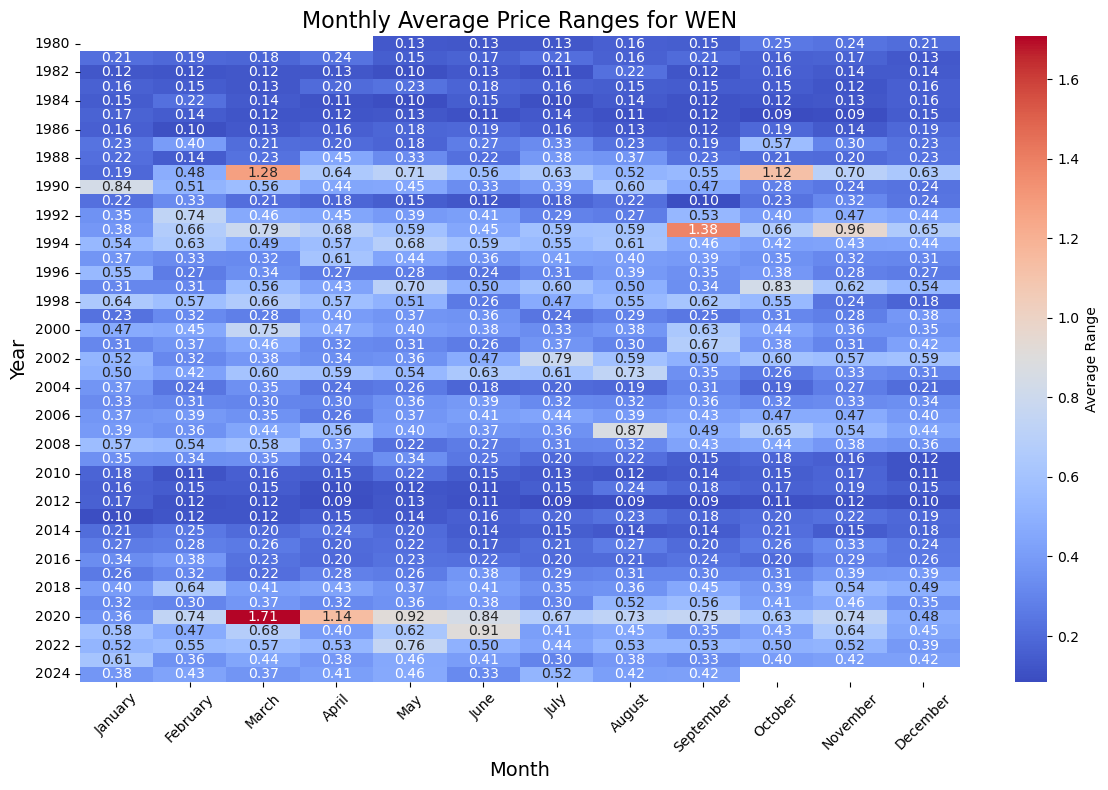

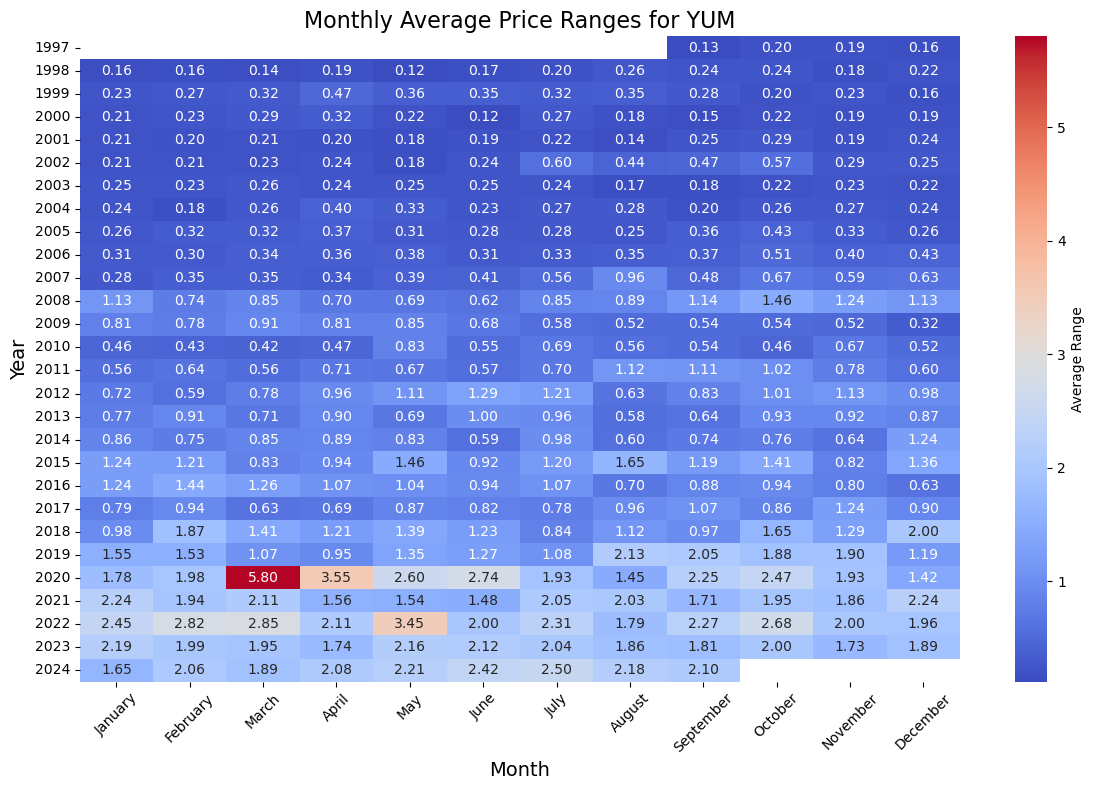

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

for company, df in dfs.items():
    if 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    else:
        print(f"'Date' column not found in data for {company}. Skipping.")
        continue

    # Extract year and month
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month_name()
    df['Range'] = df['High'] - df['Low']  

    # Calculate average range per month per year
    pivot_table = df.pivot_table(index='Year', columns='Month', values='Range', aggfunc='mean')
    pivot_table = pivot_table[['January', 'February', 'March', 'April', 'May', 'June', 'July', 
                               'August', 'September', 'October', 'November', 'December']] 

    # Plot heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={'label': 'Average Range'})
    plt.title(f"Monthly Average Price Ranges for {company}", fontsize=16)
    plt.xlabel("Month", fontsize=14)
    plt.ylabel("Year", fontsize=14)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
